In [1]:
import sys
import os
import logging

# Suppress TensorFlow / XLA logs before importing TF or src
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)
try:
    from absl import logging as absl_logging
    absl_logging.set_verbosity(absl_logging.ERROR)
except ImportError:
    pass

import subprocess

REPO_URL = "https://github.com/mociatto/EcoFair.git"
REPO_DIR = "EcoFair"

if os.path.exists("./src"):
    sys.path.insert(0, os.path.abspath("."))
elif os.path.exists(os.path.join(".", REPO_DIR, "src")):
    sys.path.insert(0, os.path.abspath(REPO_DIR))
else:
    subprocess.run(["git", "clone", "--depth", "1", REPO_URL, REPO_DIR], check=True)
    sys.path.insert(0, os.path.abspath(REPO_DIR))

from src import config, utils, data_loader, models, training, features, routing, fairness, visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Cloning into 'EcoFair'...
E0000 00:00:1771690464.893760      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771690464.951680      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771690465.398211      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771690465.398257      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771690465.398259      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771690465.398262      23 computation_placer.cc:177] computation placer already regi

In [2]:
META_TRAIN_PATH = '/kaggle/input/datasets/pasutchien/bcn20000/bcn_20k_train.csv'
META_TEST_PATH  = '/kaggle/input/datasets/pasutchien/bcn20000/bcn_20k_test.csv'
HEAVY_DIR = '/kaggle/input/notebooks/mostafaanoosha/image-feature-extractor-heavy/output/BCN20000/ResNet50'
LITE_DIR  = '/kaggle/input/notebooks/mostafaanoosha/image-feature-extractor-lite/output/BCN20000/MobileNetV3Small'

CLASSES           = ['mel', 'bcc', 'ak', 'bkl', 'nv', 'scc', 'df', 'vasc']
SAFE_CLASSES      = ['nv', 'bkl', 'df', 'vasc']
DANGEROUS_CLASSES = ['mel', 'bcc', 'scc', 'ak']

TITLE_SUFFIX = ' — BCN20000'

utils.set_seed(config.RANDOM_STATE)

In [3]:
# BCN20000 ships two separate CSV files (train / test split).
# We merge them here so the backend receives a single aligned dataset
# for cross-validation — the backend stays unaware of this detail.
meta_train = pd.read_csv(META_TRAIN_PATH)
meta_test  = pd.read_csv(META_TEST_PATH)
meta_combined = pd.concat([meta_train, meta_test], ignore_index=True)

X_heavy, X_lite, meta = data_loader.load_dataset_features(
    HEAVY_DIR, LITE_DIR, meta_combined,
    id_col='bcn_filename',
    required_columns=['diagnosis', 'age_approx', 'anatom_site_general'],
)

In [4]:
loc_risk_scores = features.compute_localization_risk_scores(meta, dangerous_classes=DANGEROUS_CLASSES)
X_tab, scaler, sex_encoder, loc_encoder, risk_scaler = features.prepare_tabular_features(
    meta, localization_risk_scores=loc_risk_scores
)
y, _ = features.prepare_labels(meta, class_names=CLASSES)
meta = meta.copy()
meta['risk_score'] = features.calculate_cumulative_risk(
    meta, risk_scaler, localization_risk_scores=loc_risk_scores
)

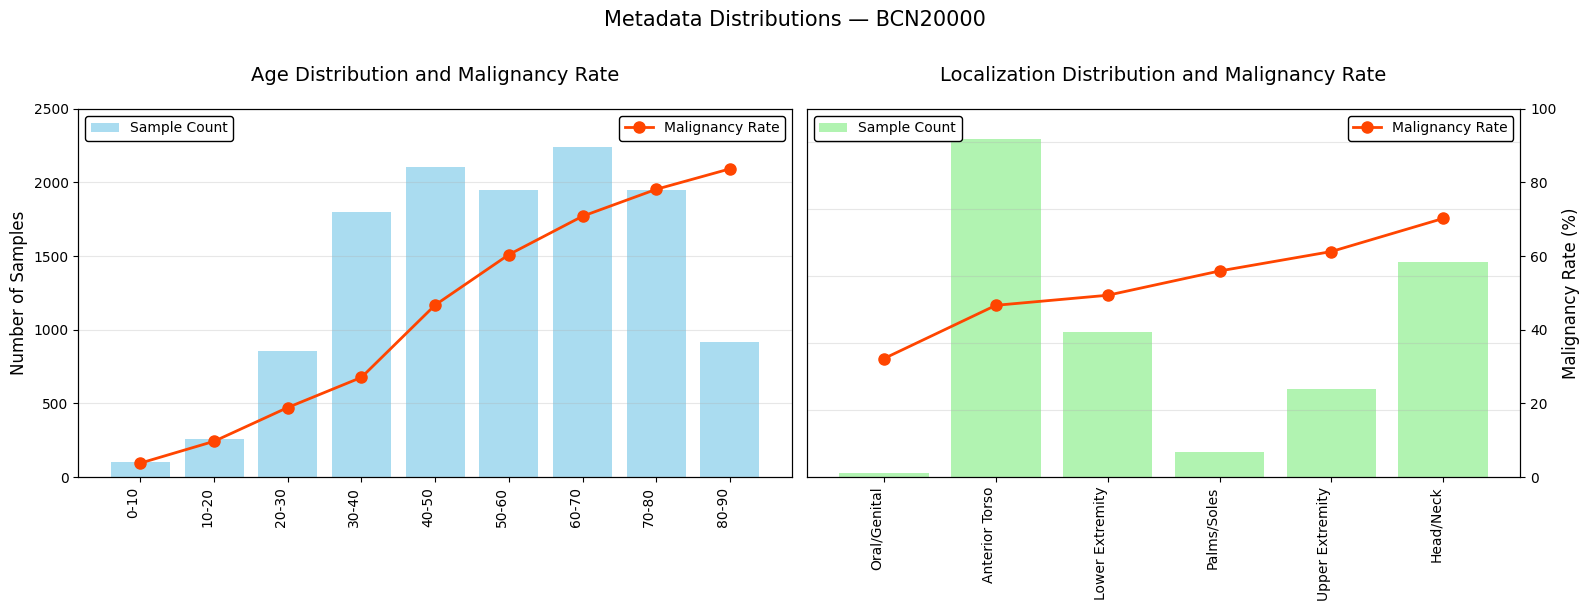

In [5]:
fig_meta = visualization.plot_metadata_distributions(meta, DANGEROUS_CLASSES, title_suffix=TITLE_SUFFIX)
plt.show()

In [6]:
fold_metrics, oof_lite, oof_heavy, oof_dynamic, route_mask_oof, route_components_oof = training.run_cv_pipeline(
    X_heavy, X_lite, X_tab, y, meta,
    class_names=CLASSES,
    safe_classes=SAFE_CLASSES,
    dangerous_classes=DANGEROUS_CLASSES,
    lite_energy_dir=LITE_DIR,
    heavy_energy_dir=HEAVY_DIR,
    n_splits=5,
    risk_scaler=risk_scaler,
)

print("\n--- Cross-Validation Results (5 Folds) ---")
print(f"Lite Accuracy:    {np.mean(fold_metrics['acc_lite']):.4f} ± {np.std(fold_metrics['acc_lite']):.4f}")
print(f"Heavy Accuracy:   {np.mean(fold_metrics['acc_heavy']):.4f} ± {np.std(fold_metrics['acc_heavy']):.4f}")
print(f"EcoFair Accuracy: {np.mean(fold_metrics['acc_dynamic']):.4f} ± {np.std(fold_metrics['acc_dynamic']):.4f}")
print(f"Routing Rate:     {np.mean(fold_metrics['routing_rate'])*100:.2f}% ± {np.std(fold_metrics['routing_rate'])*100:.2f}%")
print(f"Energy per Sample:{np.mean(fold_metrics['energy_cost']):.2f} J ± {np.std(fold_metrics['energy_cost']):.2f} J")


--- Fold 1/5 ---


I0000 00:00:1771690504.496910      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

I0000 00:00:1771690508.166871      73 service.cc:152] XLA service 0x7fcb540029c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771690508.166909      73 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771690508.683864      73 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1771690511.146008      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.5702 | Heavy: 0.5738 | EcoFair: 0.5802 | Route: 56.8% | Energy: 0.28 J/sample

--- Fold 2/5 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.5333 | Heavy: 0.5388 | EcoFair: 0.5379 | Route: 60.2% | Energy: 0.29 J/sample

--- Fold 3/5 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.5413 | Heavy: 0.5752 | EcoFair: 0.5603 | Route: 55.6% | Energy: 0.28 J/sample

--- Fold 4/5 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.5491 | Heavy: 0.5662 | EcoFair: 0.5558 | Route: 60.7% | Energy: 0.29 J/sample

--- Fold 5/5 ---


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

  Lite: 0.5323 | Heavy: 0.5186 | EcoFair: 0.5347 | Route: 57.5% | Energy: 0.29 J/sample

--- Cross-Validation Results (5 Folds) ---
Lite Accuracy:    0.5452 ± 0.0139
Heavy Accuracy:   0.5545 ± 0.0223
EcoFair Accuracy: 0.5538 ± 0.0165
Routing Rate:     58.18% ± 1.98%
Energy per Sample:0.29 J ± 0.00 J


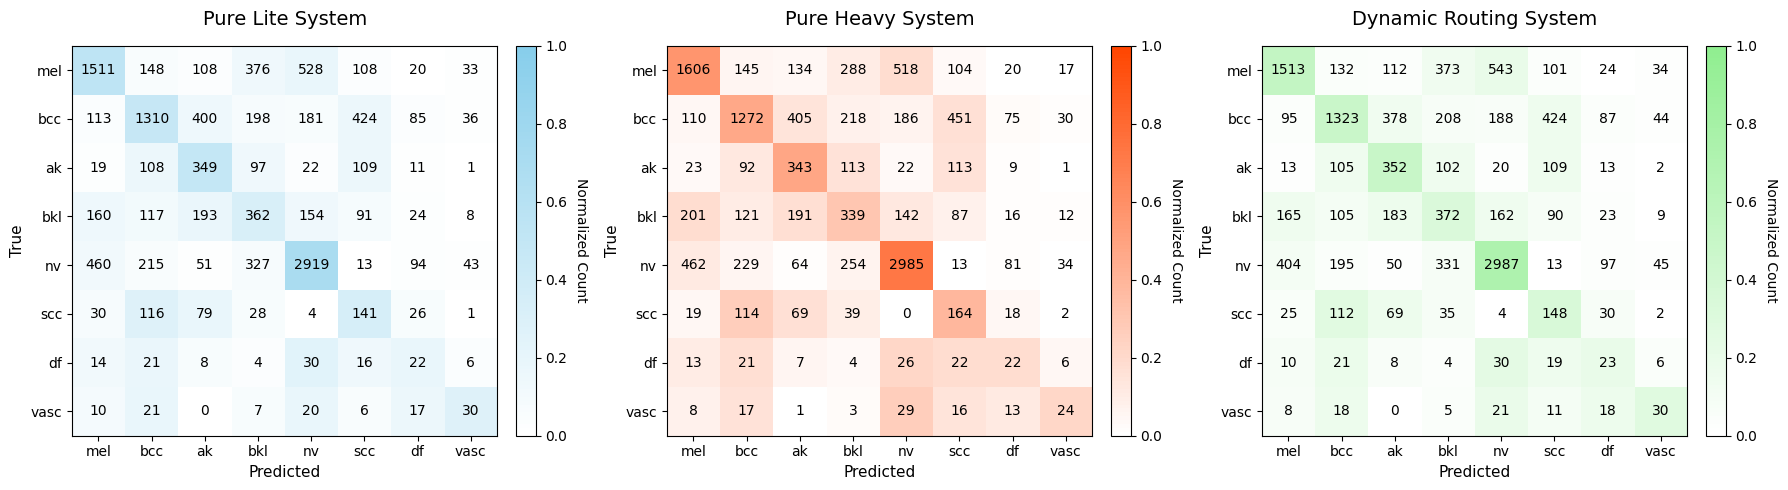

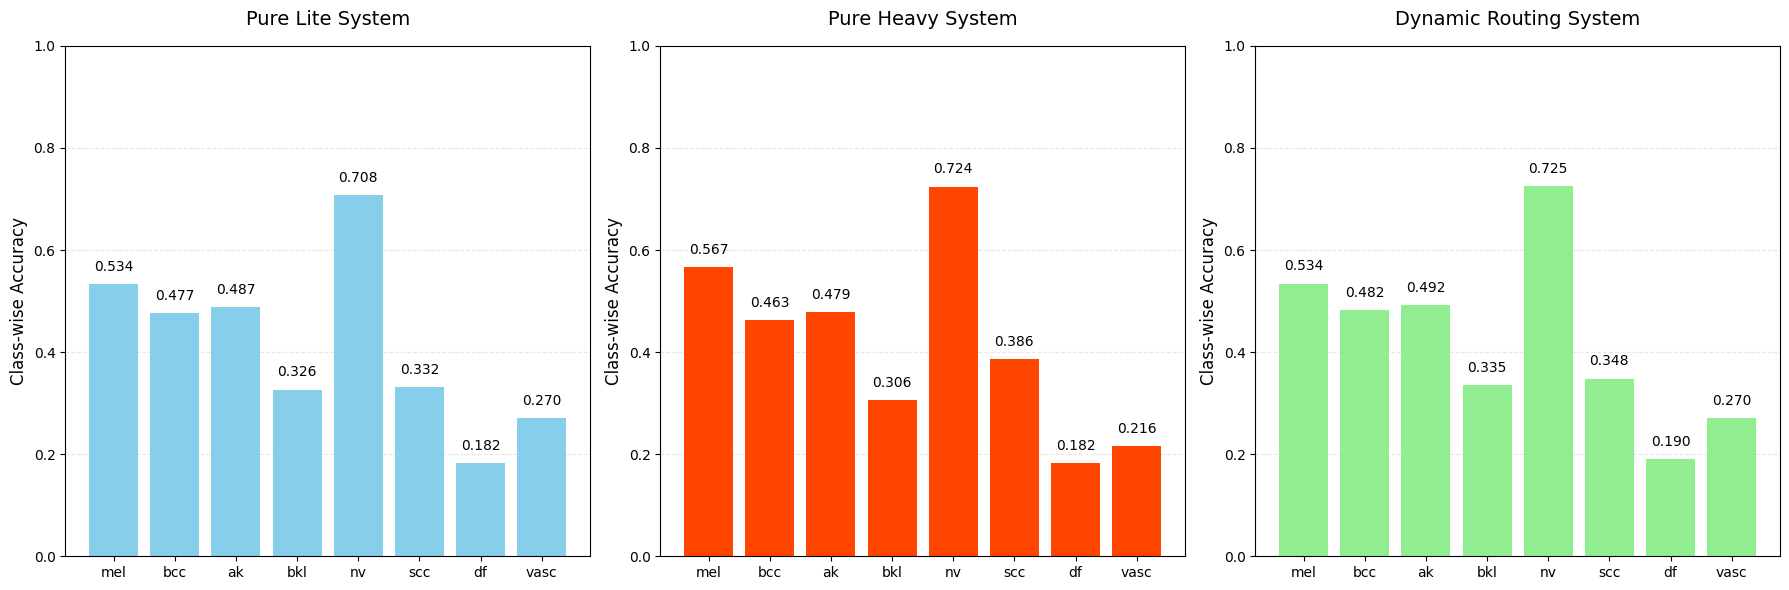

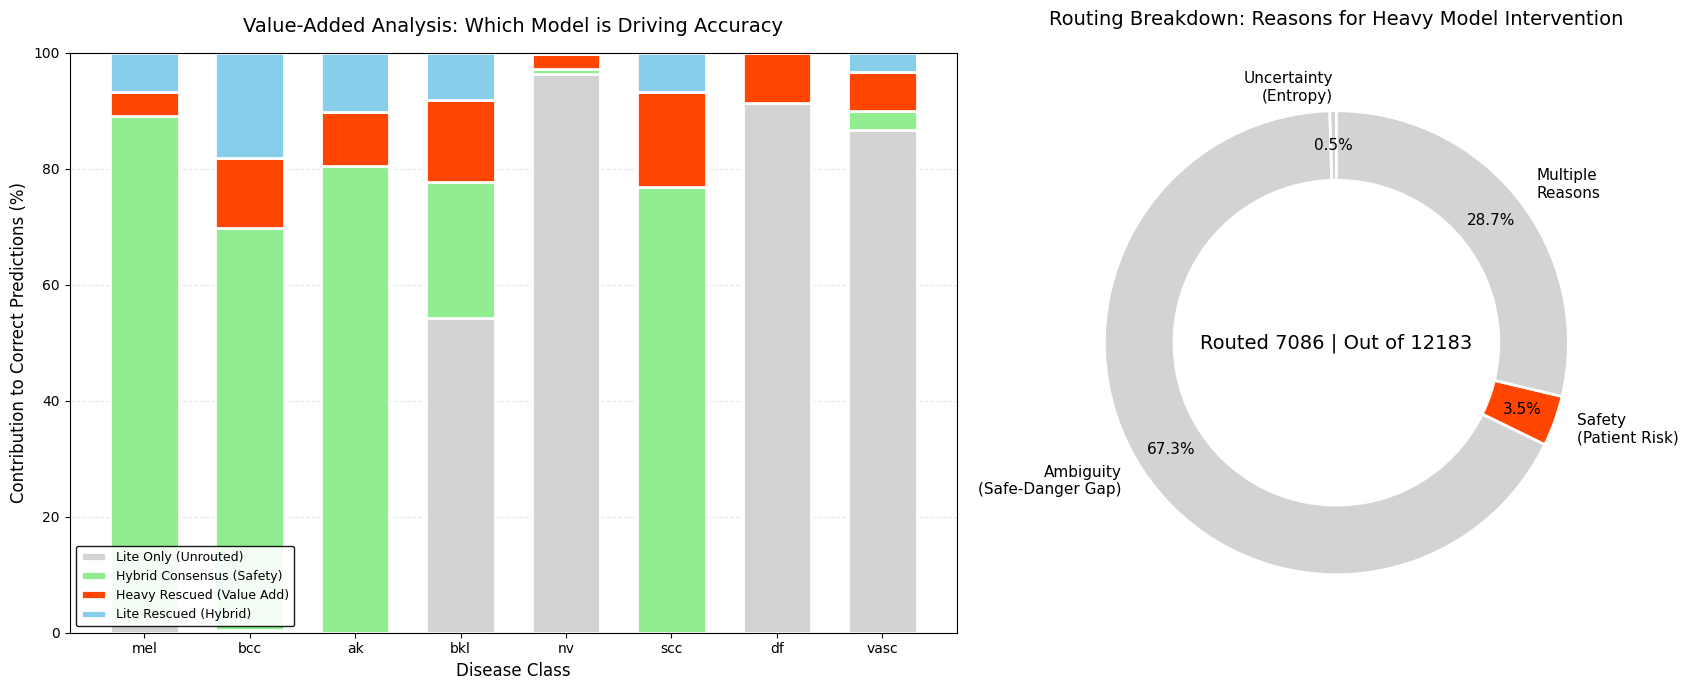

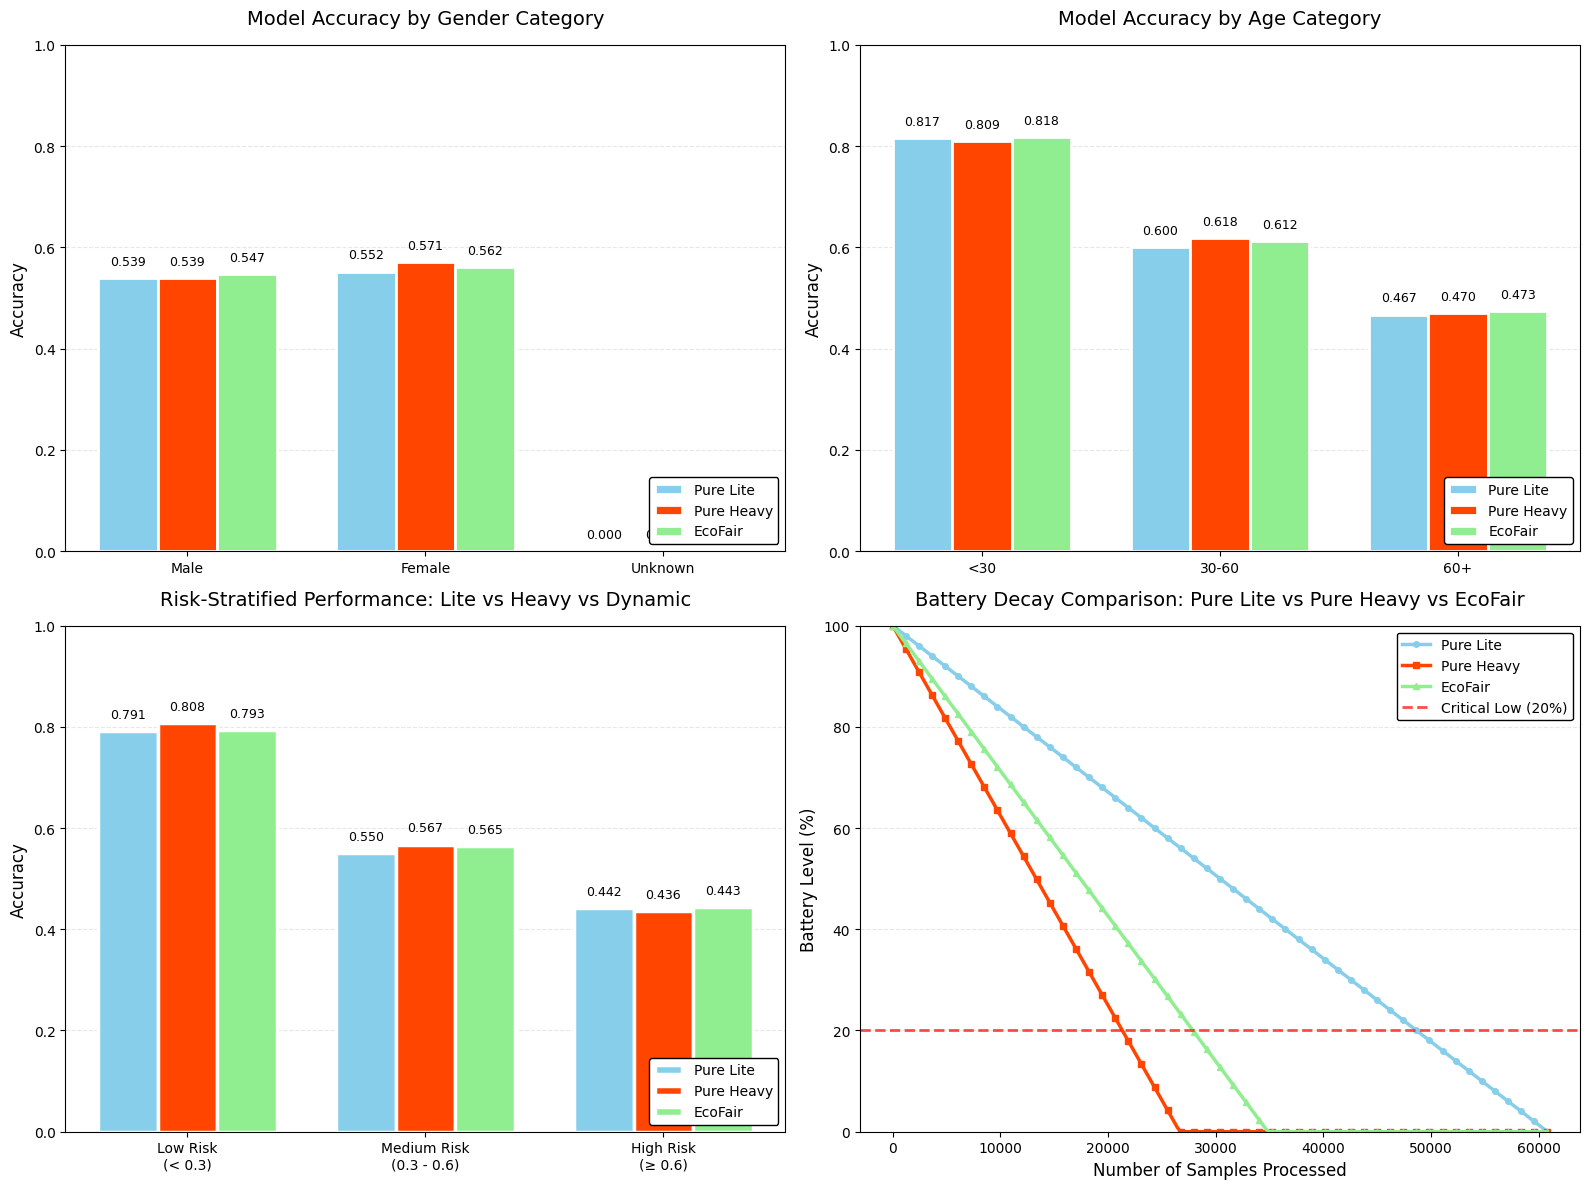

In [7]:
y_true_oof = np.argmax(y, axis=1)
entropy_oof = routing.calculate_entropy(oof_lite)
safe_indices   = [CLASSES.index(c) for c in SAFE_CLASSES]
danger_indices = [CLASSES.index(c) for c in DANGEROUS_CLASSES]
prob_safe_oof    = oof_lite[:, safe_indices].sum(axis=1)
prob_danger_oof  = oof_lite[:, danger_indices].sum(axis=1)
safe_danger_gap_oof = prob_safe_oof - prob_danger_oof

joules_lite  = utils.load_energy_stats(LITE_DIR)
joules_heavy = utils.load_energy_stats(HEAVY_DIR)
joules_lite  = joules_lite  if joules_lite  is not None else 1.0
joules_heavy = joules_heavy if joules_heavy is not None else 2.5
routing_rate_oof = route_mask_oof.sum() / len(route_mask_oof)

fig_cm = visualization.plot_confusion_matrix_comparison(
    y_true_oof, oof_lite, oof_heavy, oof_dynamic, CLASSES
)
plt.show()

fig_classwise = visualization.plot_classwise_accuracy_bars(
    y_true_oof, oof_lite, oof_heavy, oof_dynamic, CLASSES
)
plt.show()

fig_va_doughnut, axes_va_doughnut = plt.subplots(1, 2, figsize=(18, 7))
visualization.plot_value_added_bars(
    y_true_oof, oof_lite, oof_heavy, oof_dynamic, CLASSES,
    route_mask=route_mask_oof, ax=axes_va_doughnut[0]
)
visualization.plot_routing_breakdown_doughnut(
    entropy_oof, safe_danger_gap_oof, route_mask_oof, len(route_mask_oof),
    ax=axes_va_doughnut[1], route_components=route_components_oof
)
plt.tight_layout()
plt.show()

try:
    fig_comprehensive, axes_comprehensive = plt.subplots(2, 2, figsize=(16, 12))
    visualization.plot_gender_age_accuracy(
        y_true_oof, oof_lite, oof_heavy, oof_dynamic, meta, CLASSES,
        axes=(axes_comprehensive[0, 0], axes_comprehensive[0, 1])
    )
    visualization.plot_risk_stratified_accuracy(
        y_true_oof, oof_lite, oof_heavy, oof_dynamic, meta,
        risk_scaler=risk_scaler, ax=axes_comprehensive[1, 0]
    )
    visualization.plot_battery_decay(
        joules_lite, joules_heavy, routing_rate_oof, capacity_joules=10000,
        ax=axes_comprehensive[1, 1]
    )
    plt.tight_layout()
    plt.show()
except TypeError:
    try:
        plt.close(fig_comprehensive)
    except NameError:
        pass
    fig_gender_age = visualization.plot_gender_age_accuracy(
        y_true_oof, oof_lite, oof_heavy, oof_dynamic, meta, CLASSES
    )
    plt.show()
    fig_risk_battery, axes_risk_battery = plt.subplots(1, 2, figsize=(20, 6))
    visualization.plot_risk_stratified_accuracy(
        y_true_oof, oof_lite, oof_heavy, oof_dynamic, meta,
        risk_scaler=risk_scaler, ax=axes_risk_battery[0]
    )
    visualization.plot_battery_decay(
        joules_lite, joules_heavy, routing_rate_oof, capacity_joules=10000,
        ax=axes_risk_battery[1]
    )
    plt.tight_layout()
    plt.show()


--- Subgroup Accuracy ---
Class                    ak    bcc    bkl     df    mel     nv    scc   vasc
Subgroup                                                                    
Age 30-60 (n=5856)   0.9406 0.8673 0.8685 0.9547 0.8137 0.7616 0.9734 0.9756
Age 60+ (n=5108)     0.8453 0.7516 0.8140 0.9828 0.8309 0.9049 0.8264 0.9883
Age <30 (n=1219)     0.9787 0.9459 0.9385 0.9696 0.9311 0.8187 0.9992 0.9836
Sex: Female (n=5763) 0.8968 0.8494 0.8643 0.9630 0.8272 0.7978 0.9495 0.9750
Sex: Male (n=6420)   0.9114 0.8062 0.8422 0.9724 0.8375 0.8539 0.8827 0.9877

--- Equal Opportunity (True Positive Rate) ---
Goal: TPR should be roughly equal across subgroups for the same class.
'-' indicates no actual cases of that class in the subgroup.
Class                    ak    bcc    bkl     df    mel     nv    scc   vasc
Subgroup                                                                    
Age 30-60 (n=5856)   0.5024 0.4751 0.3848 0.2750 0.4845 0.7346 0.1507 0.2542
Age 60+ (n=5108)     0.

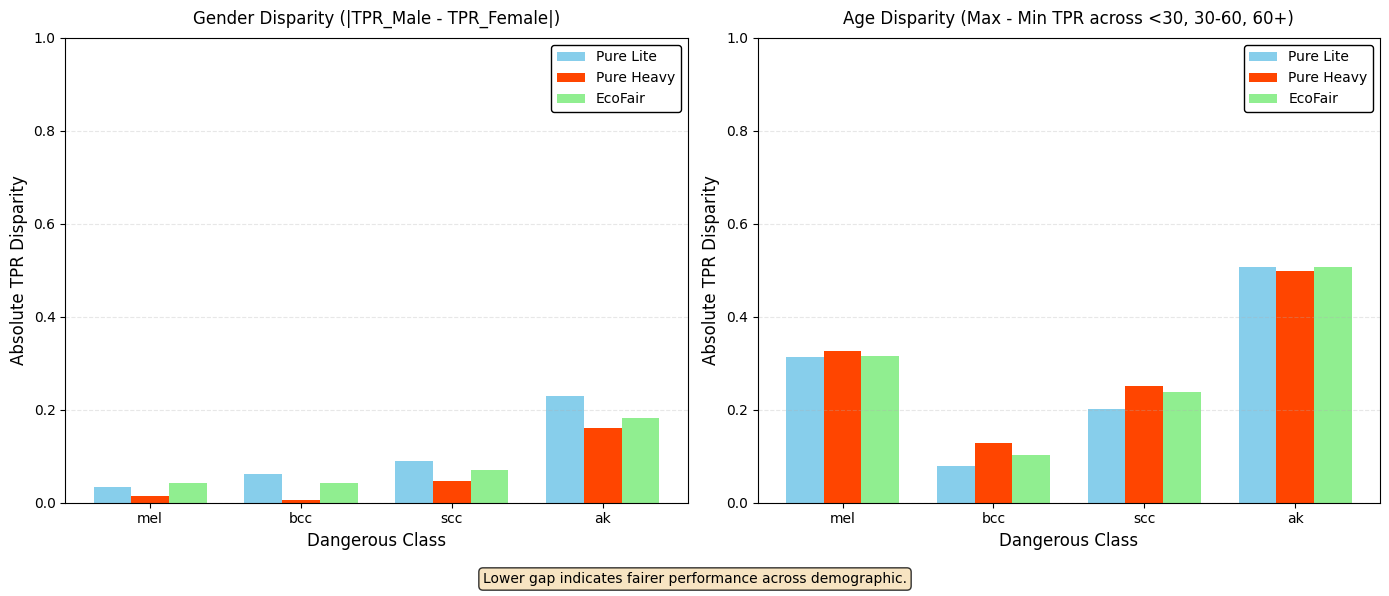

In [8]:
y_true_labels    = np.argmax(y, axis=1)
lite_pred_labels = np.argmax(oof_lite, axis=1)
heavy_pred_labels  = np.argmax(oof_heavy, axis=1)
dynamic_pred_labels = np.argmax(oof_dynamic, axis=1)

fairness_ecofair = fairness.generate_fairness_report(
    y_true_labels, dynamic_pred_labels, meta, CLASSES
)
fairness_lite = fairness.generate_fairness_report(
    y_true_labels, lite_pred_labels, meta, CLASSES
)
fairness_heavy = fairness.generate_fairness_report(
    y_true_labels, heavy_pred_labels, meta, CLASSES
)

fairness.print_fairness_audit(fairness_ecofair)
visualization.plot_fairness_disparity(
    fairness_lite, fairness_heavy, fairness_ecofair, DANGEROUS_CLASSES
)
plt.show()